In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta

## Run scenarios
Here we run the model across all five scenarios and append the results into a dictionary

In [3]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# Params
timesteps=None#7000
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

scenarios = {'BAS' : False,
             'BAU' : True,
             'NCO' : True,
             'EAG' : True,
             'COO' : True,
             'UTO' : True,
            }

results = {}
for s in scenarios:
        
    model_run = nextra(nodes,edges,flows,
                       scenario=s,
                       energy_objective=scenarios[s],
                       timesteps=timesteps,
                       #super_source=True,
                       #super_sink=True,
                       #res_factor=99,
                       #model_name='meow',
                      )

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        if s == 'BAU' and scenarios[s] == False:
            s = 'BAS'
        model_results.results_capacities['scenario']       = s
        model_results.results_storages['scenario']         = s
        model_results.results_edge_flows['scenario']       = s
        model_results.results_capacity_change['scenario']  = s
        model_results.results_costs['scenario']            = s
        # append results
        results[s] = model_results
        print('> Completed: ' + s)
    except:
        print('> FAILED! ' + s)
        os.system('say "Scenario failed"')

os.system('say "Code block finished"')

print('> Done.')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03

> Completed: BAS

> Completed: BAU

> Completed: NCO

> Completed: EAG

> Completed: COO

> Completed: UTO
> Done.


In [4]:
model_run.flows

,timestep,date,hour,day,month,year,node,value
0,1,2030-01-01 00:00:00,1,1,1,2030,israel_energy_demand,8859.595337
1,2,2030-01-01 01:00:00,2,1,1,2030,israel_energy_demand,7969.387222
2,3,2030-01-01 02:00:00,3,1,1,2030,israel_energy_demand,7393.653331
3,4,2030-01-01 03:00:00,4,1,1,2030,israel_energy_demand,7120.323143
4,5,2030-01-01 04:00:00,5,1,1,2030,israel_energy_demand,7071.696861
...,...,...,...,...,...,...,...,...
105115,8756,2030-12-31 19:00:00,20,31,12,2030,gaza_solar,0.000000
105116,8757,2030-12-31 20:00:00,21,31,12,2030,gaza_solar,0.000000
105117,8758,2030-12-31 21:00:00,22,31,12,2030,gaza_solar,0.000000
105118,8759,2030-12-31 22:00:00,23,31,12,2030,gaza_solar,0.000000


In [5]:
model_results.results_capacities.technology.unique()

array(['Wind', 'Solar', 'Gas', 'Diesel', 'Coal', 'Shale', 'Gas Reservoir',
       'Battery'], dtype=object)

In [6]:
model_results.results_capacities[model_results.results_capacities.technology.str.contains('Gas')]

,node,commodity,timestep,value,technology,territory,scenario
17520,israel_natural_gas,electricity,1,12024.0,Gas,Israel,UTO
17521,israel_natural_gas,electricity,2,12024.0,Gas,Israel,UTO
17522,israel_natural_gas,electricity,3,12024.0,Gas,Israel,UTO
17523,israel_natural_gas,electricity,4,12024.0,Gas,Israel,UTO
17524,israel_natural_gas,electricity,5,12024.0,Gas,Israel,UTO
...,...,...,...,...,...,...,...
201475,israel_gas_storage,electricity,8756,0.0,Gas Reservoir,Israel,UTO
201476,israel_gas_storage,electricity,8757,0.0,Gas Reservoir,Israel,UTO
201477,israel_gas_storage,electricity,8758,0.0,Gas Reservoir,Israel,UTO
201478,israel_gas_storage,electricity,8759,0.0,Gas Reservoir,Israel,UTO


In [7]:
model_run.flows

,timestep,date,hour,day,month,year,node,value
0,1,2030-01-01 00:00:00,1,1,1,2030,israel_energy_demand,8859.595337
1,2,2030-01-01 01:00:00,2,1,1,2030,israel_energy_demand,7969.387222
2,3,2030-01-01 02:00:00,3,1,1,2030,israel_energy_demand,7393.653331
3,4,2030-01-01 03:00:00,4,1,1,2030,israel_energy_demand,7120.323143
4,5,2030-01-01 04:00:00,5,1,1,2030,israel_energy_demand,7071.696861
...,...,...,...,...,...,...,...,...
105115,8756,2030-12-31 19:00:00,20,31,12,2030,gaza_solar,0.000000
105116,8757,2030-12-31 20:00:00,21,31,12,2030,gaza_solar,0.000000
105117,8758,2030-12-31 21:00:00,22,31,12,2030,gaza_solar,0.000000
105118,8759,2030-12-31 22:00:00,23,31,12,2030,gaza_solar,0.000000


In [8]:
model_run.technologies

['demand',
 'junction',
 'wind',
 'solar',
 'natural gas',
 'diesel',
 'coal',
 'ccgt',
 'generic',
 'shale',
 'gas reservoir',
 'battery']

In [9]:
model_results.plot_flows_sankey(height=500,title='Debugging')

## Create costs figure
This figure will show the required costs ($) in 2030 per scenario as a bar chart

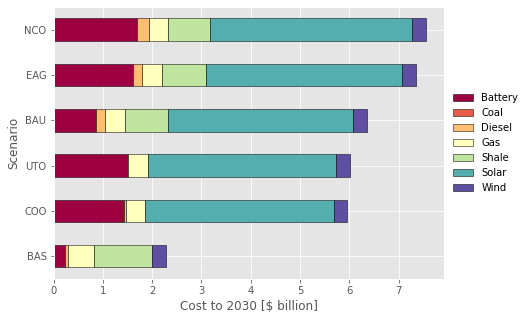

In [10]:
def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs

# run function
costs = merge_cost_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex')
# sort by ascending
costs['total'] = costs.sum(axis=1)
costs = costs.sort_values("total").drop('total',axis=1)

# convert to billion
costs = costs.mul(10**-9)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
costs.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Cost to 2030 [$ billion]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
f.savefig('../outputs/figures/totex_by_scenario.pdf',bbox_inches='tight')

In [11]:
costs = merge_cost_data(results)

costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex')


costs

technology,Battery,Coal,Diesel,Gas,Shale,Solar,Wind
scenario,,,,,,,
BAS,2.257374e+08,0.0,6.532636e+07,5.222391e+08,1.187131e+09,0.000000e+00,279769000.0
BAU,8.558989e+08,0.0,1.870471e+08,3.982857e+08,8.838760e+08,3.750440e+09,279769000.0
COO,1.425509e+09,0.0,3.627404e+07,3.982857e+08,0.000000e+00,3.822516e+09,279769000.0
EAG,1.610959e+09,0.0,1.912448e+08,3.982857e+08,8.852495e+08,3.991370e+09,279769000.0
NCO,1.697543e+09,0.0,2.353924e+08,3.982857e+08,8.479257e+08,4.089656e+09,279769000.0
UTO,1.510031e+09,0.0,0.000000e+00,3.982857e+08,0.000000e+00,3.817565e+09,279769000.0


## Create capacities figure
This figure will show the required capacity (GW) in 2030 per scenario as a bar chart

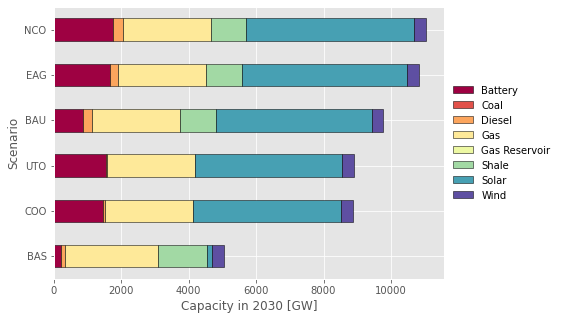

In [12]:
# run function
capacities = merge_capacity_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
capacities.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [GW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
f.savefig('../outputs/figures/capacity_by_scenario.pdf',bbox_inches='tight')

## Relative capacity change
This figure shows the capacity change (GW) per scenario relative to BAS

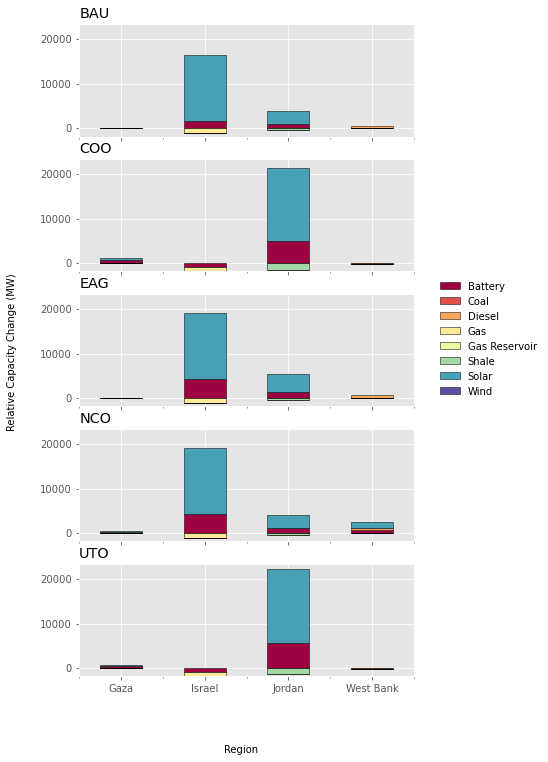

In [13]:
delta = get_relative_capacities(results)

f,ax = plt.subplots(ncols=1,nrows=5,figsize=(6,12),sharex=True,sharey=True)

count=0
for s in delta.scenario.unique():
    idx = delta.loc[delta.scenario.isin([s])]
    idx = idx.pivot_table(index=['territory'],columns=['technology'],values='relative_change')
    idx.plot.bar(stacked=True,rot=0,ax=ax[count],cmap='Spectral',edgecolor='black',legend=False)
    #ax[count].set_ylim([-5000,20000])
    ax[count].set_xlabel(None)
    ax[count].set_title(s,loc='left')
    count=count+1

plt.legend(loc='center left', bbox_to_anchor=(1.05, 3),frameon=False)

f.text(0.5, 0.04, 'Region', ha='center', va='center')
f.text(-0.03, 0.5, 'Relative Capacity Change (MW)', ha='center', va='center', rotation='vertical')

f.savefig('../outputs/figures/relative_capacity_by_scenario.pdf',bbox_inches='tight')

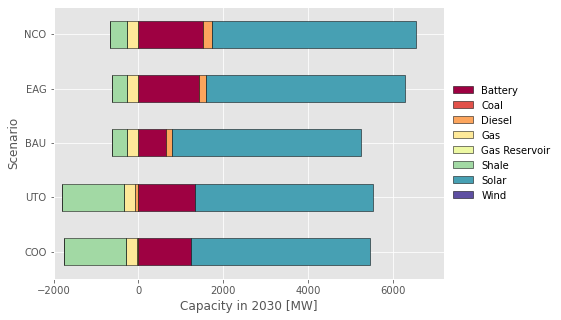

In [14]:
# plot
delta = get_relative_capacities(results)
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
delta = delta.pivot_table(index=['scenario'],columns=['technology'],values='relative_change')
# sort by ascending
delta['total'] = delta.sum(axis=1)
delta = delta.sort_values("total").drop('total',axis=1)
delta.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [MW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
ax.set_xlim([-2000,7200])
f.savefig('../outputs/figures/relative_capacity_by_scenario_2.pdf',bbox_inches='tight')

## Emissions by scenario
Create a boxplot of emissions (y-axis) by scenario (x-axis)

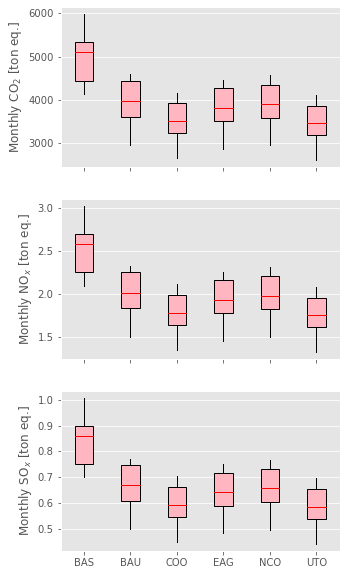

In [15]:
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    '''
    '''
    df['sox'] = df[on] * df['technology'].map(sox)
    return df


def map_nox_emissions(df,on):
    '''
    '''
    df['nox'] = df[on] * df['technology'].map(nox)
    return df


def map_co2_emissions(df,on):
    '''
    '''
    df['co2'] = df[on] * df['technology'].map(co2)
    return df


merged_flows = pd.DataFrame()
for k in results.keys():
    sn = get_source_nodes(results[k].nodes).name.to_list()
    df = results[k].results_edge_flows.loc[results[k].results_edge_flows.from_id.isin(sn)]
    df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
    df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
    df = map_territory(df,on='from_id')
    df = map_technology(df,on='from_id')
    merged_flows = merged_flows.append(df,ignore_index=True)

merged_flows = map_sox_emissions(merged_flows,on='value')
merged_flows = map_nox_emissions(merged_flows,on='value')
merged_flows = map_co2_emissions(merged_flows,on='value')

merged_flows = merged_flows.groupby(by=['month','year','scenario']).sum().reset_index()

# adjust units
merged_flows['co2'] = merged_flows['co2'].divide(10**6)
merged_flows['nox'] = merged_flows['nox'].divide(10**6)
merged_flows['sox'] = merged_flows['sox'].divide(10**6)

props = {'boxprops':{'facecolor':'lightpink', 'edgecolor':'black','linewidth':1},
         'medianprops':{'color':'red','linewidth':1},
         'whiskerprops':{'color':'black','linewidth':1},
         'capprops':{'color':'none'}}

f,ax = plt.subplots(nrows=3,ncols=1,figsize=(5,10),sharex=True)

sns.boxplot(x='scenario',y='co2',data=merged_flows,showfliers=False,
            ax=ax[0],width=0.4,**props)

sns.boxplot(x='scenario',y='nox',data=merged_flows,showfliers=False,
            ax=ax[1],width=0.4,**props)

sns.boxplot(x='scenario',y='sox',data=merged_flows,showfliers=False,
            ax=ax[2],width=0.4,**props)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('Monthly CO$_2$ [ton eq.]')
ax[1].set_ylabel('Monthly NO$_x$ [ton eq.]')
ax[2].set_ylabel('Monthly SO$_x$ [ton eq.]')

f.savefig('../outputs/figures/emissions_boxplot.pdf',bbox_inches='tight')

## Self-sufficiency vs cooperation
Here I'll analyse the relationship between self-sufficiency and cooperation in the context of the Palestinian Authority. 

In [113]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# Params
timesteps=None#7000
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

ss_factors = [i/100 for i in np.arange(0, 105, 25).tolist()]

results = {}
for s in ss_factors:
    
    model_run = nextra(nodes,edges,flows,
                       scenario='COO',
                       energy_objective=True,
                       timesteps=timesteps,
                       self_sufficiency_factor=s)

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        if s == 'BAU' and scenarios[s] == False:
            s = 'BAS'
        model_results.results_capacities['self_sufficiency_factor']       = s
        model_results.results_storages['self_sufficiency_factor']         = s
        model_results.results_edge_flows['self_sufficiency_factor']       = s
        model_results.results_capacity_change['self_sufficiency_factor']  = s
        model_results.results_costs['self_sufficiency_factor']            = s
        # append results
        results[ 'COO_' + str(s) ] = model_results
        print('> Completed: ' + str(s))
    except:
        print('> FAILED! ' + str(s))
        os.system('say "Scenario failed"')


> Completed: 0.0

> Completed: 0.25

> Completed: 0.5

> Completed: 0.75

> Completed: 1.0


In [122]:
capacities = merge_capacity_data(results)
capacities = capacities.groupby(by=['territory','self_sufficiency_factor','node']).max().reset_index()
capacities = capacities.loc[capacities.territory.isin(['Gaza','West Bank'])].reset_index(drop=True)
#capacities = capacities.groupby(by=['territory','self_sufficiency_factor']).sum().reset_index()
capacities = capacities.loc[capacities.value>0]
capacities

,territory,self_sufficiency_factor,node,commodity,timestep,value,technology
0,Gaza,0.00,gaza_battery_storage,electricity,8760,406.884963,Battery
1,Gaza,0.00,gaza_diesel,electricity,8760,60.000000,Diesel
3,Gaza,0.00,gaza_solar,electricity,8760,316.845650,Solar
4,Gaza,0.25,gaza_battery_storage,electricity,8760,817.890613,Battery
5,Gaza,0.25,gaza_diesel,electricity,8760,60.000000,Diesel
7,Gaza,0.25,gaza_solar,electricity,8760,372.847430,Solar
8,Gaza,0.50,gaza_battery_storage,electricity,8760,824.315945,Battery
9,Gaza,0.50,gaza_diesel,electricity,8760,60.000000,Diesel
11,Gaza,0.50,gaza_solar,electricity,8760,373.823923,Solar
12,Gaza,0.75,gaza_battery_storage,electricity,8760,993.449861,Battery


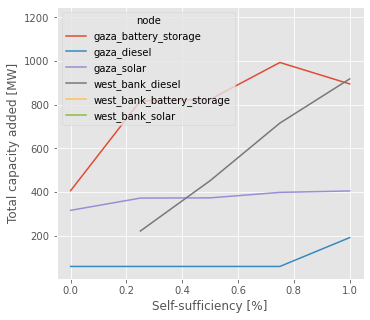

In [123]:
f,ax = plt.subplots(nrows=1,ncols=1,figsize=(5.5,5))

sns.lineplot(x='self_sufficiency_factor',
             y='value',
             hue='node',
             ax=ax,
             data=capacities)

plt.xlabel('Self-sufficiency [%]')
plt.ylabel('Total capacity added [MW]')
f.savefig('../outputs/figures/coop_tradeoff.pdf',bbox_inches='tight')

In [109]:
[i/100 for i in np.arange(0, 105, 25).tolist()]

[0.0, 0.25, 0.5, 0.75, 1.0]

## Visualise flows
This figure visualises flows between each territory

###### NOTE TO SELF:
Here I'm trying to generate a set of sankey plots in a loop (currently testing just for NCO) but can't get the plotly figure to save... getting the error:

> The colour should be an integer rather than string... maybe?
> When colour arguments are commented out, I get the following error: 01 The kaleido executable is required by the kaleido Python library, but it was not included

In [16]:
# import os
# import seaborn as sns
# import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

# import sys
# sys.path.append('../')

# from infrasim.optimise import *
# from infrasim.utils import *

# # SUBFUNCTIONS
# def merge_capacity_data(results_dict):
#     '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
#     '''
#     # init blank df
#     capacities = pd.DataFrame()
#     # loop results 
#     for k in results_dict.keys():
#         df = results_dict[k].results_capacities
#         capacities = capacities.append(df,ignore_index=True)
#     return capacities


# def get_relative_capacities(results_dict):
#     capacities = merge_capacity_data(results_dict)
#     # get bas and delta dfs
#     bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
#     delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
#     # group
#     bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
#     delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
#     # map baseline capacities
#     bas = bas.set_index('node')['value'].to_dict()
#     delta['bas_cap'] = delta.node.map(bas)
#     # compute delta
#     delta['relative_change'] = delta['value'] - delta['bas_cap']
#     return delta

# #File paths
# nodes = '../data/nextra/spatial/network/nodes.shp'
# edges = '../data/nextra/spatial/network/edges.shp'
# flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# # Params
# timesteps=24#7000
# super_source=False
# pprint=True
# save_figures=True

# infrasim_init_directories()

# scenarios = {
#              'NCO' : True,
#             }

# results = {}
# for s in scenarios:
        
#     model_run = nextra(nodes,edges,flows,
#                        scenario=s,
#                        energy_objective=scenarios[s],
#                        timesteps=timesteps,
#                        #super_source=True,
#                        #super_sink=True,
#                        #res_factor=99,
#                        #model_name='meow',
#                       )

#     model_run.build()
#     model_run.run(pprint=False)
#     try:
#         model_results = model_run.get_results()
#         # add scenarios to results
#         if s == 'BAU' and scenarios[s] == False:
#             s = 'BAS'
#         model_results.results_capacities['scenario']       = s
#         model_results.results_storages['scenario']         = s
#         model_results.results_edge_flows['scenario']       = s
#         model_results.results_capacity_change['scenario']  = s
#         model_results.results_costs['scenario']            = s
#         # append results
#         results[s] = model_results
#         print('> Completed: ' + s)
#     except:
#         print('> FAILED! ' + s)
#         os.system('say "Scenario failed"')

# #os.system('say "Code block finished"')

# print('> Done.')

# results['NCO'].plot_flows_sankey(height=500,title='No Cooperation')

In [17]:
results.keys()

dict_keys(['BAS', 'BAU', 'NCO', 'EAG', 'COO', 'UTO'])